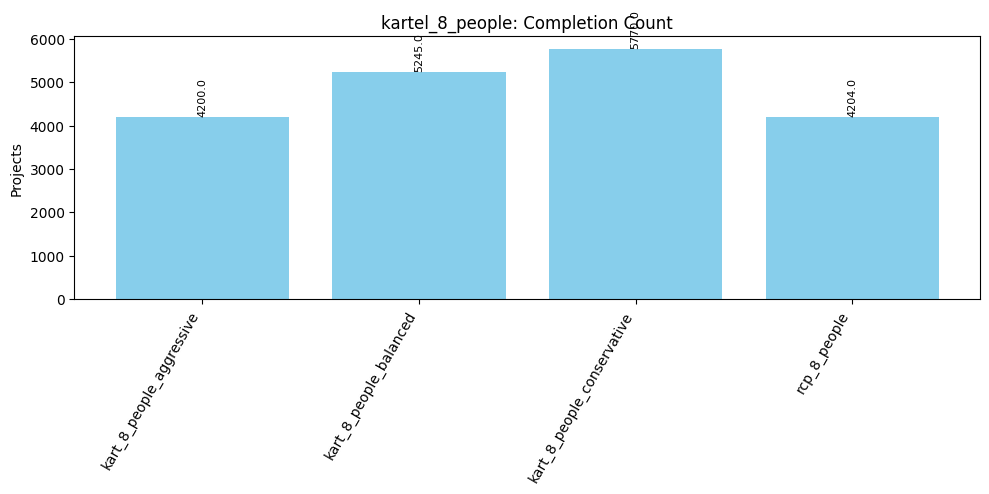

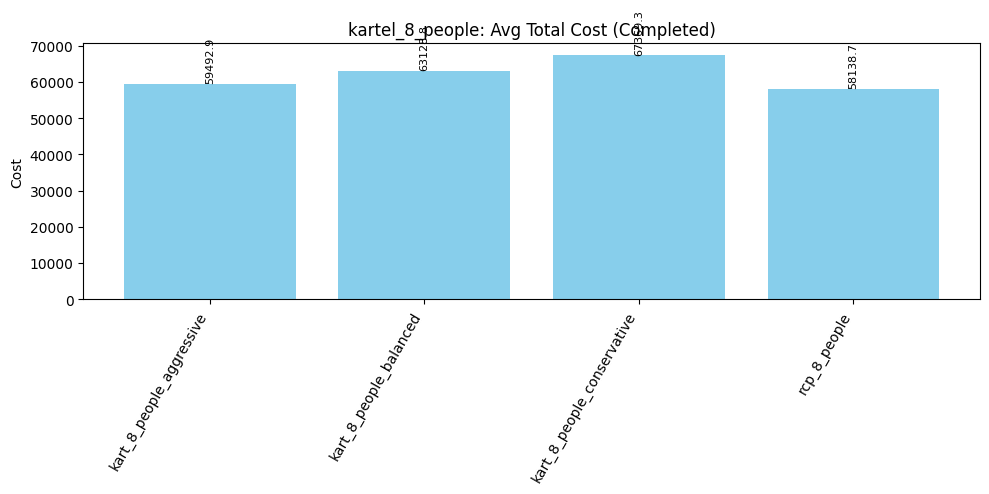

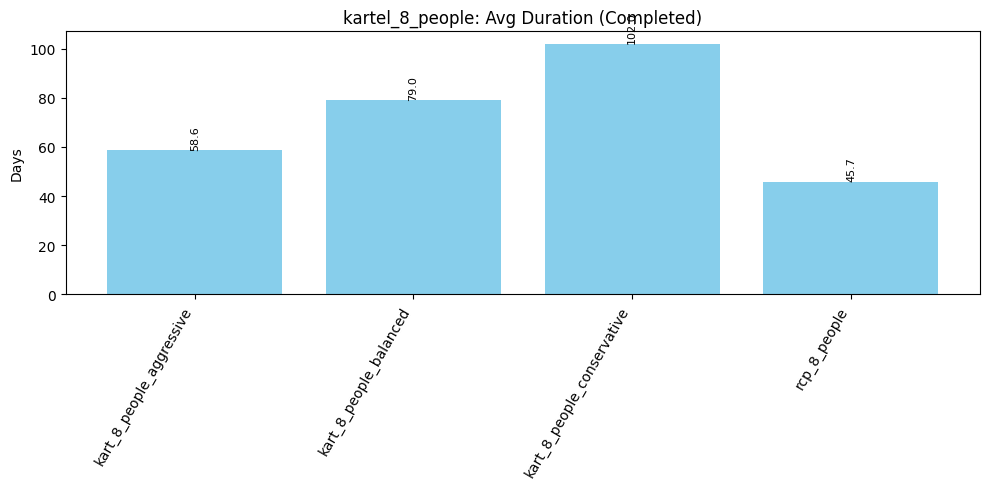

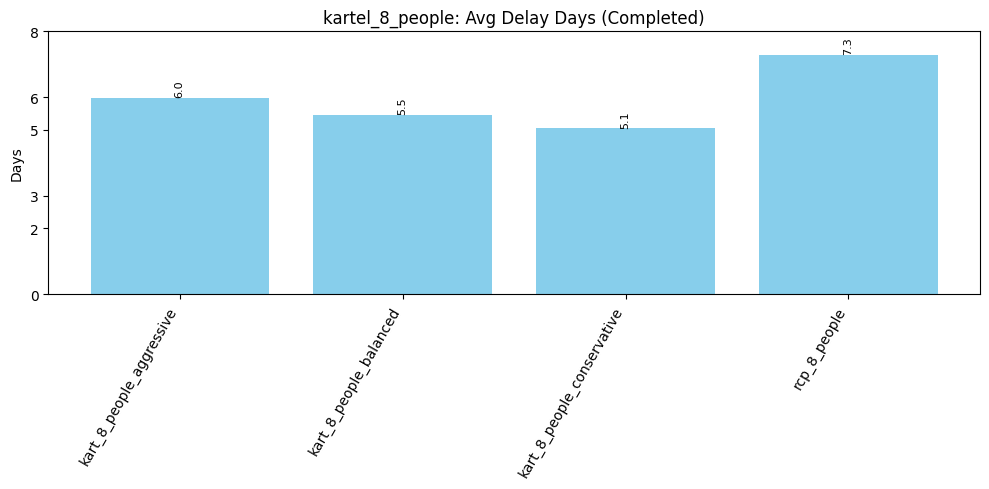

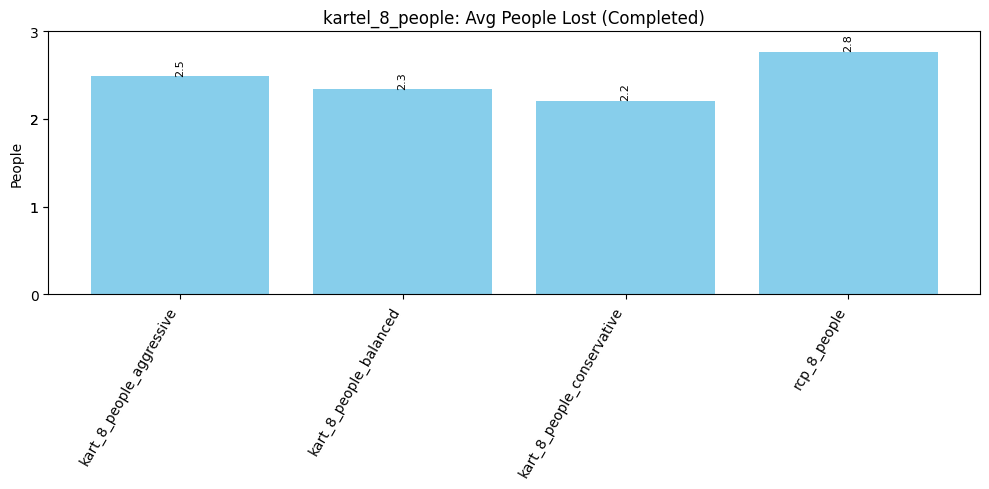

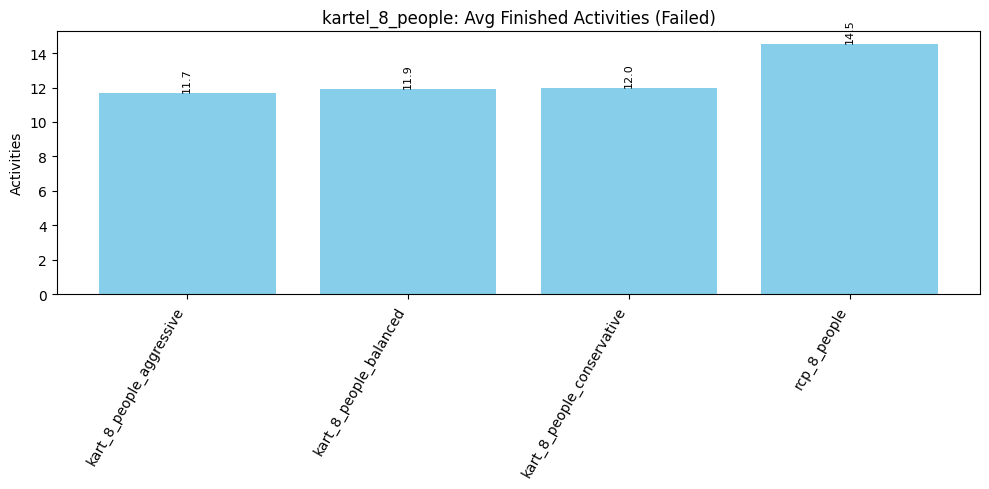

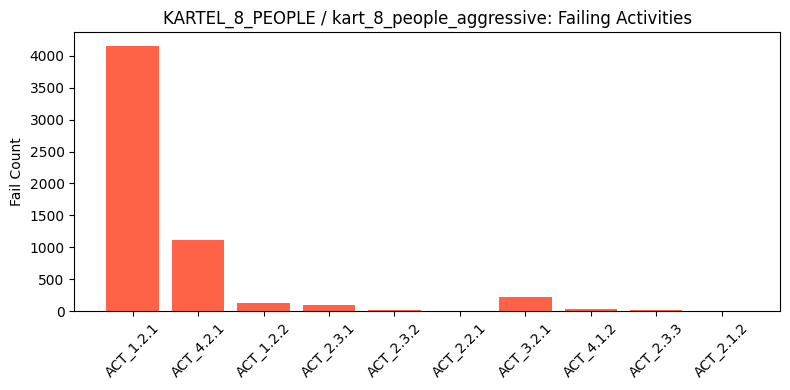

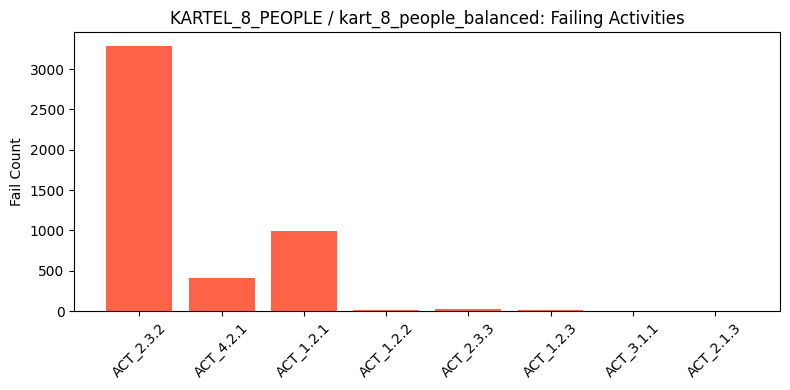

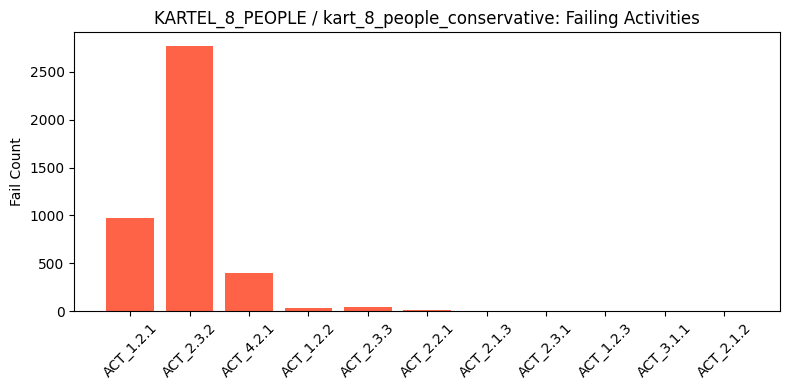

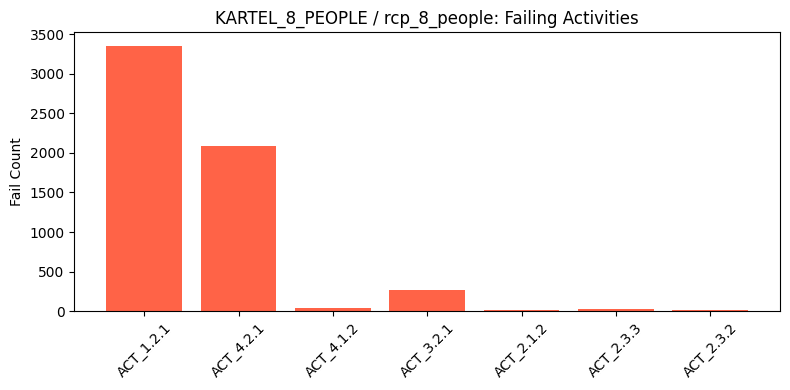

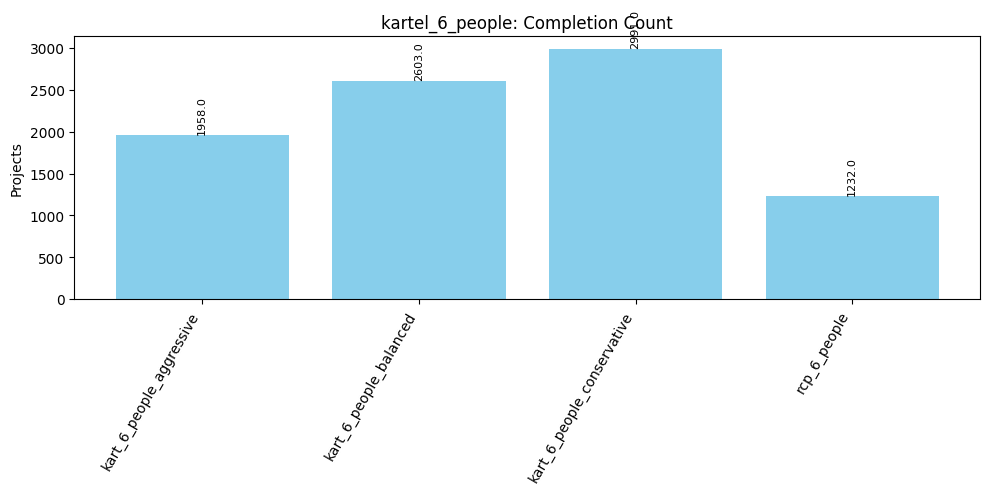

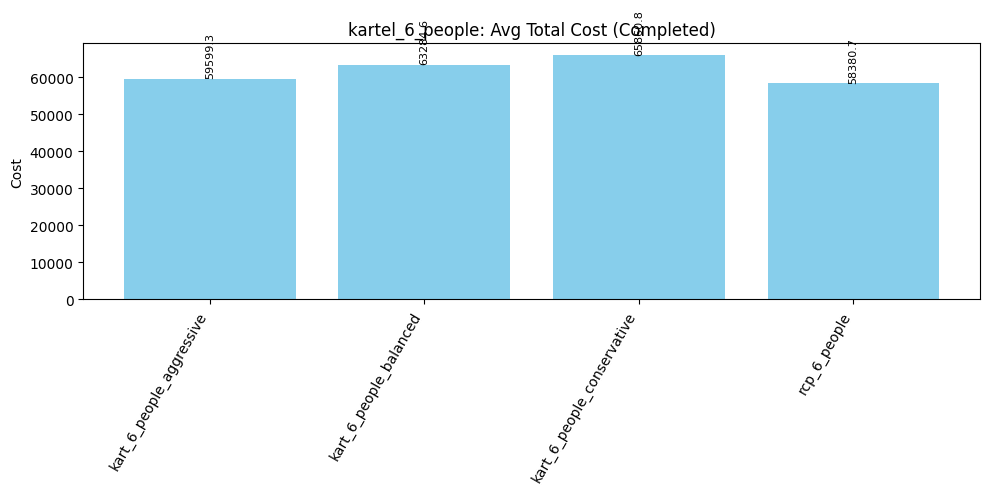

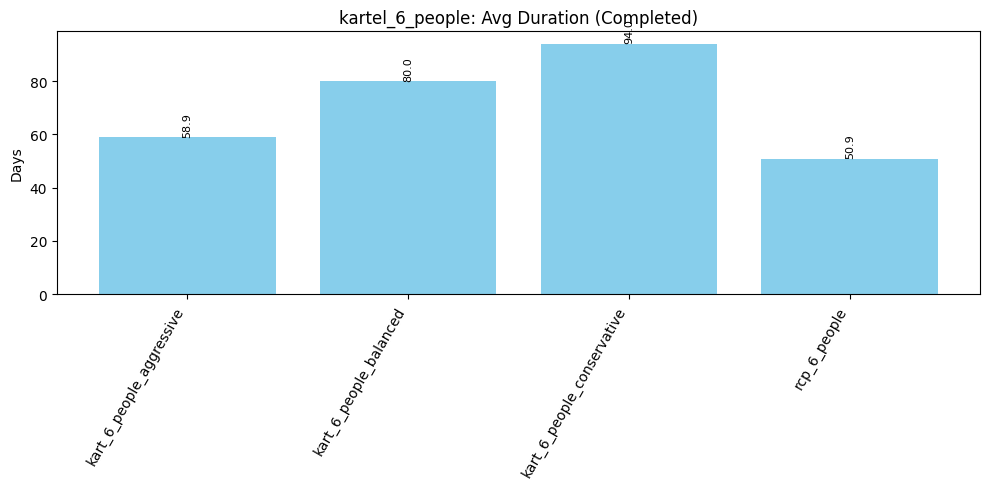

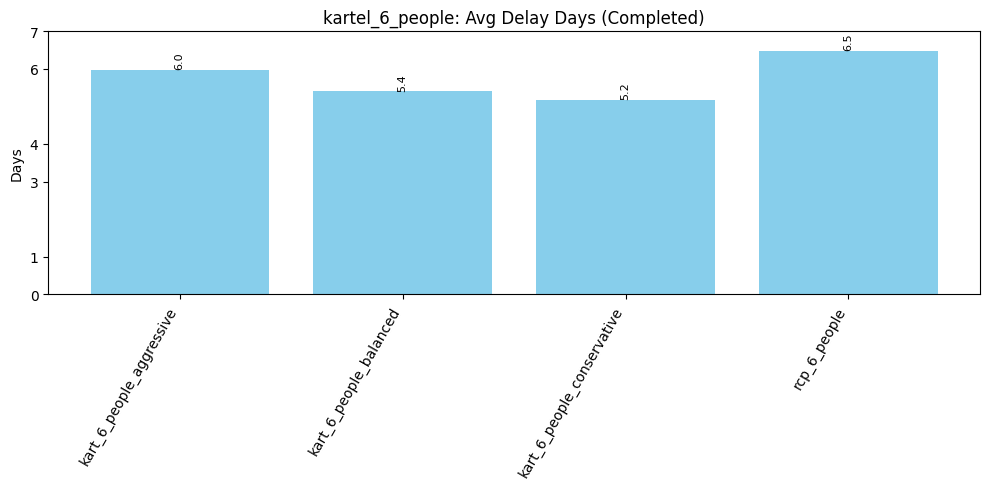

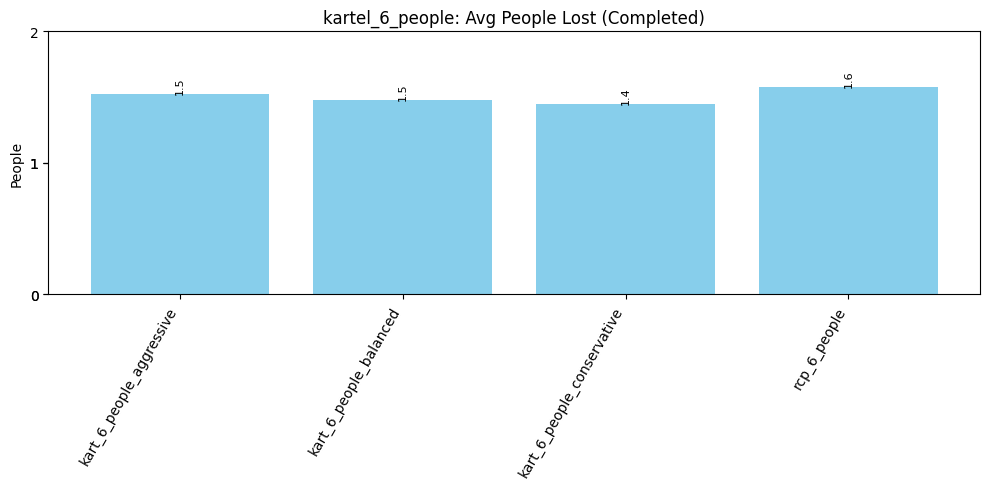

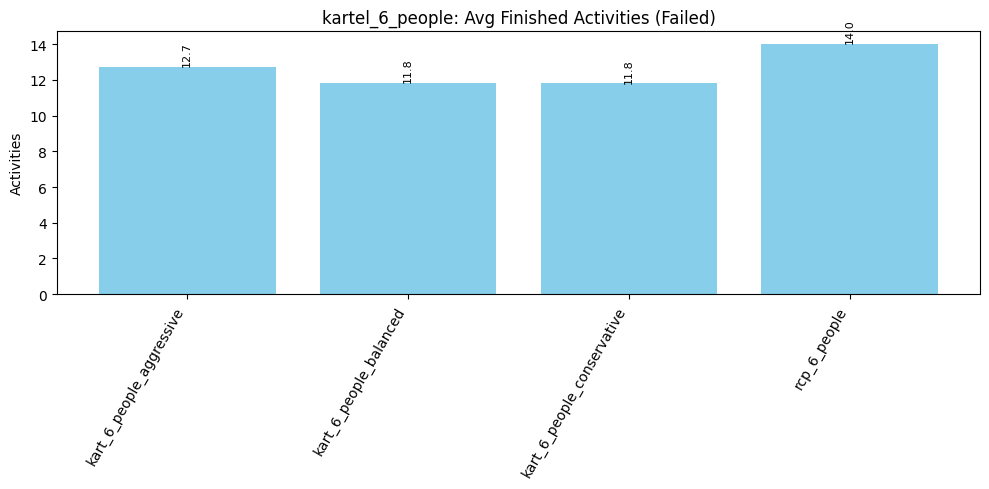

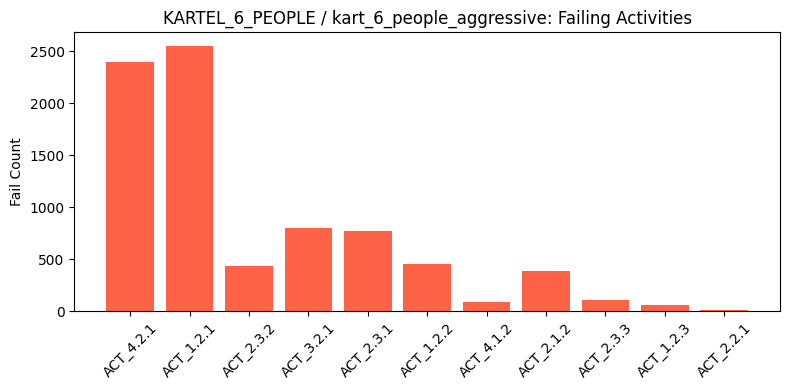

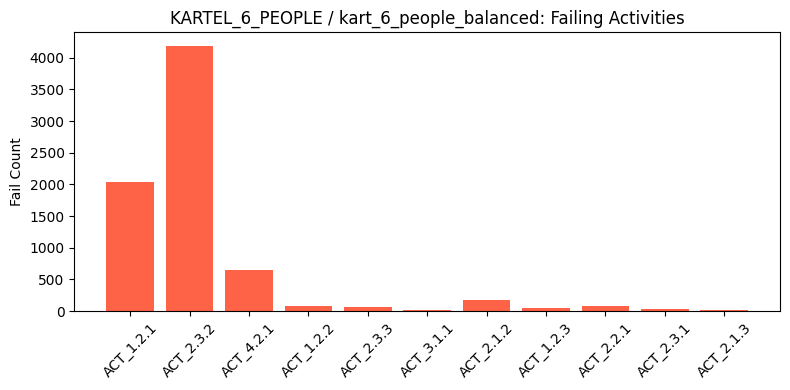

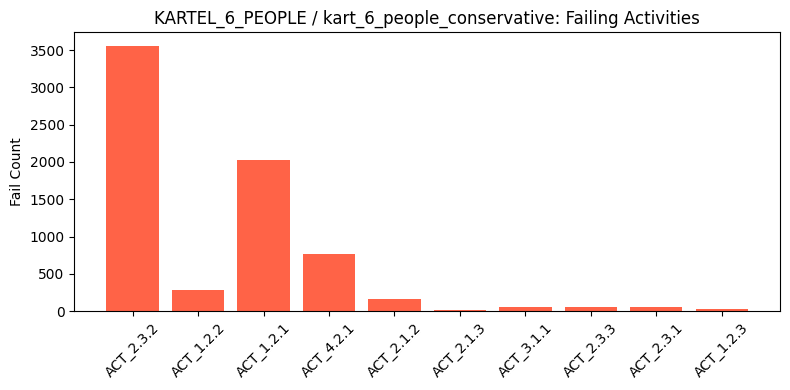

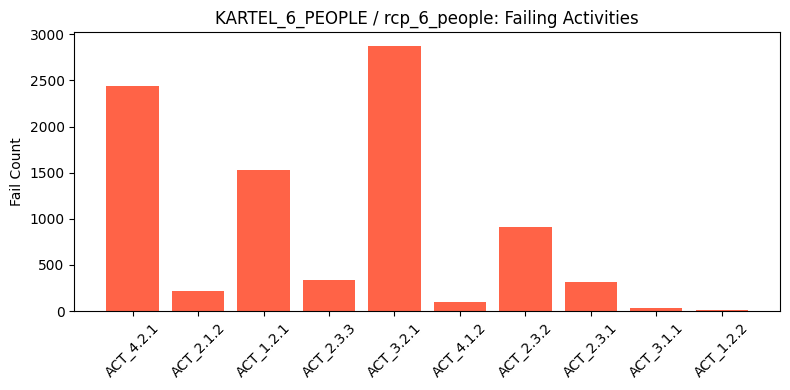


===== KARTEL_8_PEOPLE GROUP SUMMARY =====

=== kart_8_people_aggressive ===
  - Completed Duration Avg: 58.57 | Stddev: 0.50
  - Failed Duration Avg:    29.85 | Stddev: 14.58
  - Cost Avg (Completed):   59492.89 | Stddev: 4107.00
  - Total (150k - cost) Completed: Avg: 90507.11 | Stddev: 4107.00

=== kart_8_people_balanced ===
  - Completed Duration Avg: 79.00 | Stddev: 0.00
  - Failed Duration Avg:    32.89 | Stddev: 11.11
  - Cost Avg (Completed):   63128.75 | Stddev: 3912.90
  - Total (150k - cost) Completed: Avg: 86871.25 | Stddev: 3912.90

=== kart_8_people_conservative ===
  - Completed Duration Avg: 102.00 | Stddev: 0.00
  - Failed Duration Avg:    45.31 | Stddev: 15.11
  - Cost Avg (Completed):   67369.27 | Stddev: 3774.01
  - Total (150k - cost) Completed: Avg: 82630.73 | Stddev: 3774.01

=== rcp_8_people ===
  - Completed Duration Avg: 45.73 | Stddev: 0.44
  - Failed Duration Avg:    30.02 | Stddev: 11.70
  - Cost Avg (Completed):   58138.71 | Stddev: 4483.49
  - Total (150k

In [29]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

BASE_FOLDER = r"C:\Users\cobev\OneDrive - UGent\2024_2025_Informatica\sem2\project_management\planning-application\project-management\Website\data\v2\results"
GROUPS = ["kartel_8_people", "kartel_6_people"]

def load_and_process_group(group):
    path = os.path.join(BASE_FOLDER, group)
    group_stats = {}

    for file_name in os.listdir(path):
        if not file_name.endswith(".json"):
            continue

        with open(os.path.join(path, file_name), "r") as f:
            data = json.load(f)

        stats_entry = {
            "completion_rate": 0,
            "on_fail_finished_activities": [],
            "on_fail_total_duration": [],
            "fail_counts": {},
            "completed_total_cost": [],
            "completed_delay_days": [],
            "completed_people_lost": [],
            "completed_total_duration": [],
            "completed_total_completed": []
        }

        for run in data:
            if run.get("projectFinished", False):
                stats_entry["completion_rate"] += 1
                cost = run.get("totalCost", 0)
                delay = run.get("totalDelayDays", 0)
                lost = len(run.get("peopleLost", []))
                duration = run.get("totalProjectDuration", 0)

                stats_entry["completed_total_cost"].append(cost)
                stats_entry["completed_delay_days"].append(delay)
                stats_entry["completed_people_lost"].append(lost)
                stats_entry["completed_total_duration"].append(duration)
                stats_entry["completed_total_completed"].append(150000 - cost)
            else:
                finished = len(run.get("finishedActivities", []))
                duration = run.get("totalProjectDuration", 0)
                stats_entry["on_fail_finished_activities"].append(finished)
                stats_entry["on_fail_total_duration"].append(duration)

                failing_activity = run.get("failingActivity", {}).get("id", "unknown")
                stats_entry["fail_counts"][failing_activity] = stats_entry["fail_counts"].get(failing_activity, 0) + 1

        group_stats[file_name] = stats_entry

    return group_stats

# Load both groups
all_stats = {group: load_and_process_group(group) for group in GROUPS}

# --- Plotting utilities ---
def bar_plot(values, labels, title, ylabel, highlight_zeros=False, round_ticks=False):
    fig_width = max(10, len(labels) * 1.2)
    plt.figure(figsize=(fig_width, 5))
    plt.bar(labels, values, color='skyblue')

    for i, v in enumerate(values):
        if highlight_zeros and v == 0:
            plt.text(i, 0.5, "No Completed", ha='center', color='red', fontsize=8)
        else:
            plt.text(i, v + 0.01 * max(values), f"{v:.1f}", ha='center', fontsize=8, rotation=90)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=60, ha='right')

    if round_ticks:
        y_max = max(values) * 1.1
        plt.yticks(np.round(np.linspace(0, y_max, num=6)))

    plt.tight_layout()
    plt.show()

def shorten_label(name):
    base = os.path.splitext(name)[0]
    return base.replace("input_", "").replace("underground_", "").replace("_results", "")

def plot_group(group_name, group_data):
    labels = [shorten_label(name) for name in group_data.keys()]
    completion = [v["completion_rate"] for v in group_data.values()]
    avg_costs = [np.mean(v["completed_total_cost"]) if v["completed_total_cost"] else 0 for v in group_data.values()]
    avg_duration = [np.mean(v["completed_total_duration"]) if v["completed_total_duration"] else 0 for v in group_data.values()]
    avg_delays = [np.mean(v["completed_delay_days"]) if v["completed_delay_days"] else 0 for v in group_data.values()]
    avg_lost = [np.mean(v["completed_people_lost"]) if v["completed_people_lost"] else 0 for v in group_data.values()]
    avg_finished_on_fail = [np.mean(v["on_fail_finished_activities"]) if v["on_fail_finished_activities"] else 0 for v in group_data.values()]

    bar_plot(completion, labels, f"{group_name}: Completion Count", "Projects", highlight_zeros=True)
    bar_plot(avg_costs, labels, f"{group_name}: Avg Total Cost (Completed)", "Cost")
    bar_plot(avg_duration, labels, f"{group_name}: Avg Duration (Completed)", "Days")
    bar_plot(avg_delays, labels, f"{group_name}: Avg Delay Days (Completed)", "Days", round_ticks=True)
    bar_plot(avg_lost, labels, f"{group_name}: Avg People Lost (Completed)", "People", round_ticks=True)
    bar_plot(avg_finished_on_fail, labels, f"{group_name}: Avg Finished Activities (Failed)", "Activities")

    for file_name, stats in group_data.items():
        if stats["fail_counts"]:
            ids = list(stats["fail_counts"].keys())
            counts = list(stats["fail_counts"].values())
            plt.figure(figsize=(8, 4))
            plt.bar(ids, counts, color='tomato')
            plt.title(f"{group_name.upper()} / {shorten_label(file_name)}: Failing Activities")
            plt.ylabel("Fail Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

def print_group_stats(group_name, group_data):
    print(f"\n===== {group_name.upper()} GROUP SUMMARY =====")
    for file_name, stats in group_data.items():
        print(f"\n=== {shorten_label(file_name)} ===")
        if stats["completed_total_duration"]:
            print(f"  - Completed Duration Avg: {np.mean(stats['completed_total_duration']):.2f} | Stddev: {np.std(stats['completed_total_duration']):.2f}")
        if stats["on_fail_total_duration"]:
            print(f"  - Failed Duration Avg:    {np.mean(stats['on_fail_total_duration']):.2f} | Stddev: {np.std(stats['on_fail_total_duration']):.2f}")
        if stats["completed_total_cost"]:
            print(f"  - Cost Avg (Completed):   {np.mean(stats['completed_total_cost']):.2f} | Stddev: {np.std(stats['completed_total_cost']):.2f}")
        if stats["completed_total_completed"]:
            print(f"  - Total (150k - cost) Completed: Avg: {np.mean(stats['completed_total_completed']):.2f} | Stddev: {np.std(stats['completed_total_completed']):.2f}")

# Run all
for group_name, group_data in all_stats.items():
    plot_group(group_name, group_data)

for group_name, group_data in all_stats.items():
    print_group_stats(group_name, group_data)
